# Sorted vs. Truth

author: steeve.laquitaine@epfl.ch  
date: 31.10.2023  

TODO:
- KSlabel good make them closer
- remove fr_min in sorting and re-sort horvath vivo and silico

TODO: 
- adding a new campaign improved the match between silico and vivo distributions in L1 
- create longer simulations: add another 10 min to probe 2 and 3

### Prerequisites

```bash
# save metadata to Ground truth and Sorted Sorting Extractors
sbatch cluster/postpro/postpro_silico_horvath_probe1.sbatch
sbatch cluster/postpro/postpro_silico_horvath_probe2.sbatch
sbatch cluster/postpro/postpro_silico_horvath_probe3.sbatch
```

## Setup

Activate `npx_10m_384_ch_unit_classes` environment (select interpreter - find envs/ path - add kernel)

In [139]:
%load_ext autoreload
%autoreload 2
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
import spikeinterface as si

# SET PROJECT PATH

PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/preprint_2023"
os.chdir(PROJ_PATH)
from src.nodes.utils import get_config
from src.nodes.postpro import spikestats

# SETUP EXPERIMENTS

# vivo
EXPERIMENT = "vivo_horvath"   
data_conf_horvath_1, _ = get_config(EXPERIMENT, "probe_1").values()
RECORDING_PATH_HORVATH_1 = data_conf_horvath_1["preprocessing"]["output"]["trace_file_path"]
SORTED_PATH_VIVO_1 = data_conf_horvath_1["sorting"]["sorters"]["kilosort3"]["output"]

data_conf_horvath_2, _ = get_config(EXPERIMENT, "probe_2").values()
RECORDING_PATH_HORVATH_2 = data_conf_horvath_2["preprocessing"]["output"]["trace_file_path"]
SORTED_PATH_VIVO_2 = data_conf_horvath_2["sorting"]["sorters"]["kilosort3"]["output"]

data_conf_horvath_3, _ = get_config(EXPERIMENT, "probe_3").values()
RECORDING_PATH_HORVATH_3 = data_conf_horvath_3["preprocessing"]["output"]["trace_file_path"]
SORTED_PATH_VIVO_3 = data_conf_horvath_3["sorting"]["sorters"]["kilosort3"]["output"]

# silico
data_conf_silico_1, param_conf_silico_1 = get_config("silico_horvath", "concatenated/probe_1").values()
RECORDING_PATH_SILICO_1 = data_conf_silico_1["preprocessing"]["output"]["trace_file_path"]
SORTED_PATH_SILICO_1 = data_conf_silico_1["sorting"]["sorters"]["kilosort3"]["output"]

data_conf_silico_2, param_conf_silico_2 = get_config("silico_horvath", "concatenated/probe_2").values()
RECORDING_PATH_SILICO_2 = data_conf_silico_2["preprocessing"]["output"]["trace_file_path"]
SORTED_PATH_SILICO_2 = data_conf_silico_2["sorting"]["sorters"]["kilosort3"]["output"]

data_conf_silico_3, param_conf_silico_3 = get_config("silico_horvath", "concatenated/probe_3").values()
RECORDING_PATH_SILICO_3 = data_conf_silico_3["preprocessing"]["output"]["trace_file_path"]
SORTED_PATH_SILICO_3 = data_conf_silico_3["sorting"]["sorters"]["kilosort3"]["output"]

# SETUP WAVEFORMS

MS_BEFORE = 3
MS_AFTER = 3

# SETUP PLOT 

# set lognormal plot parameters
log_x_min = -5
log_x_max = 3.0
nbins = 20

# IF you don't want to use the feature, set the value to 1E100
# t_dec = 3600 # seconds until experimenter decides a cell is silent
t_dec = 1^100 # seconds until experimenter decides a cell is silent

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2023-12-08 11:29:32,266 - root - utils.py - get_config - INFO - Reading experiment config.


2023-12-08 11:29:32,275 - root - utils.py - get_config - INFO - Reading experiment config. - done
2023-12-08 11:29:32,275 - root - utils.py - get_config - INFO - Reading experiment config.
2023-12-08 11:29:32,282 - root - utils.py - get_config - INFO - Reading experiment config. - done
2023-12-08 11:29:32,283 - root - utils.py - get_config - INFO - Reading experiment config.
2023-12-08 11:29:32,290 - root - utils.py - get_config - INFO - Reading experiment config. - done
2023-12-08 11:29:32,291 - root - utils.py - get_config - INFO - Reading experiment config.
2023-12-08 11:29:32,301 - root - utils.py - get_config - INFO - Reading experiment config. - done
2023-12-08 11:29:32,302 - root - utils.py - get_config - INFO - Reading experiment config.
2023-12-08 11:29:32,313 - root - utils.py - get_config - INFO - Reading experiment config. - done
2023-12-08 11:29:32,314 - root - utils.py - get_config - INFO - Reading experiment config.
2023-12-08 11:29:32,324 - root - utils.py - get_config 

### Population

#### Compute

In [140]:
# SILICO
silico_paths = [SORTED_PATH_SILICO_1, SORTED_PATH_SILICO_2, SORTED_PATH_SILICO_3]

firing_rate_all = []
layer_all = []
depth_all = []
unit_id_all = []
KSLabel_all = []
amplitude_all = []
false_positives_all = []

for ix, sorted_path in enumerate(silico_paths):
    Sorting = si.load_extractor(sorted_path)
    # record
    unit_id_all += Sorting.unit_ids.tolist()
    firing_rate_all += Sorting.get_property("firing_rates").astype(np.float32).tolist()
    layer_all += Sorting.get_property("layer").tolist()
    KSLabel_all += Sorting.get_property("KSLabel").tolist()
    amplitude_all += Sorting.get_property("Amplitude").tolist()
    false_positives_all += Sorting.get_property("false_positives").tolist()
    depth_all += len(Sorting.unit_ids) * [ix + 1]


# store in dataframe
df_silico = pd.DataFrame(
    np.array(
        [
            depth_all,
            layer_all,
            firing_rate_all,
            KSLabel_all,
            amplitude_all,
            false_positives_all,
        ]
    ).T,
    index=unit_id_all,
    columns=[
        "depth",
        "layer",
        "firing_rate",
        "kslabel",
        "amplitude",
        "false_positives",
    ],
)

# VIVO

vivo_paths = [SORTED_PATH_VIVO_1, SORTED_PATH_VIVO_2, SORTED_PATH_VIVO_3]

firing_rate_all = []
layer_all = []
depth_all = []
unit_id_all = []
KSLabel_all = []
amplitude_all = []

for ix, sorted_path in enumerate(vivo_paths):
    Sorting = si.load_extractor(sorted_path)
    # record
    unit_id_all += Sorting.unit_ids.tolist()
    firing_rate_all += Sorting.get_property("firing_rates").astype(np.float32).tolist()
    layer_all += Sorting.get_property("layer").tolist()
    KSLabel_all += Sorting.get_property("KSLabel").tolist()
    amplitude_all += Sorting.get_property("Amplitude").tolist()
    depth_all += len(Sorting.unit_ids) * [ix + 1]

# store in dataframe
df_vivo = pd.DataFrame(
    np.array([depth_all, layer_all, firing_rate_all, KSLabel_all, amplitude_all]).T,
    index=unit_id_all,
    columns=["depth", "layer", "firing_rate", "kslabel", "amplitude"],
)
print(df_vivo.shape)
print(df_silico.shape)

(682, 5)
(1934, 6)


### Apply quality filters

- evidence that false positives are low amplitude sorted spikes
- evidence that L1 silico best matches L1 vivo when selecting higher amplitude spikes
- evidence that other layers best match when selecting all spikes

In [141]:
# well isolated (not multi-units)
df_vivo = df_vivo[df_vivo["kslabel"] == "good"]
df_silico = df_silico[df_silico["kslabel"] == "good"]
print(df_vivo.shape)
print(df_silico.shape)

(211, 5)
(441, 6)


#### Plot

#### Plot

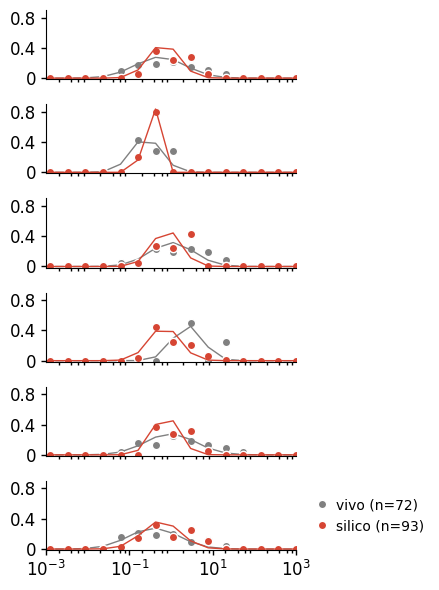

In [189]:
MARKERSIZE = 6
Y_MAX = 0.9
X_MIN = 1e-3
X_MAX = 1e3

# fig, axes = plt.subplots(5, 1, figsize=(4.5, 6))
# fig, axes = plt.subplots(5, 1, figsize=(4.4, 6))
fig, axes = plt.subplots(6, 1, figsize=(4.5, 6))

silico_color = (0.84, 0.27, 0.2)
vivo_color = (0.5, 0.5, 0.5)

# layer colors
# l1_color = (0.5, 0.5, 0.5)
# l2_3_color = (1, 0, 0.5)
# l4_color = (0.9, 0, 0.9)
# l5_color = (0.5, 0.5, 1)
# l6_color = (0.1, 0.8, 0.6)

l1_color = vivo_color
l2_3_color = vivo_color
l4_color = vivo_color
l5_color = vivo_color
l6_color = vivo_color

# Population -----------------
# horvath
spikestats.plot_firing_rate_hist_vs_lognorm(
    df_vivo["firing_rate"].values.astype(np.float32),
    log_x_min,
    log_x_max,
    nbins,
    t_dec,
    axes[0],
    label=f"""vivo (n={len(df_vivo["firing_rate"].values.astype(np.float32))})""",
    color=vivo_color,
    markerfacecolor=vivo_color,
    markeredgecolor="w",
    linestyle="-",
    markersize=MARKERSIZE,
    legend=False,
    lognormal=True,
)

# silico
spikestats.plot_firing_rate_hist_vs_lognorm(
    df_silico["firing_rate"].values.astype(np.float32),
    log_x_min,
    log_x_max,
    nbins,
    t_dec,
    axes[0],
    label=f"""silico (n={len(df_silico["firing_rate"].values.astype(np.float32))})""",
    color=silico_color,
    markerfacecolor=silico_color,
    markeredgecolor="w",
    linestyle="-",
    markersize=MARKERSIZE,
    legend=False,
    lognormal=True,
)
# axes[0].legend(frameon=False, loc="center left", bbox_to_anchor=(1, 0.5), handletextpad=0.01)
axes[0].set_ylim([-0.015, Y_MAX])
axes[0].set_xticks([])
axes[0].set_xlim([X_MIN, X_MAX])
axes[0].tick_params(axis="y", labelsize=12)

# L1 -----
# vivo
y = df_vivo["firing_rate"][df_vivo["layer"] == "L1"].values.astype(np.float32)
l1_out_vivo = spikestats.plot_firing_rate_hist_vs_lognorm(
    y,
    log_x_min,
    log_x_max,
    nbins,
    t_dec,
    axes[1],
    label=f"vivo (n={len(y)})",
    color=l1_color,
    markerfacecolor=l1_color,
    markeredgecolor="w",
    linestyle="-",
    markersize=MARKERSIZE,
    legend=False,
    lognormal=True,
)
# silico
y = df_silico["firing_rate"][df_silico["layer"] == "L1"].values.astype(np.float32)
l1_out_silico = spikestats.plot_firing_rate_hist_vs_lognorm(
    y,
    log_x_min,
    log_x_max,
    nbins,
    t_dec,
    axes[1],
    label=f"silico (n={len(y)})",
    color=silico_color,
    markerfacecolor=silico_color,
    markeredgecolor="w",
    linestyle="-",
    markersize=MARKERSIZE,
    legend=False,
    lognormal=True,
)
# axes[1].legend(frameon=False, loc="center left", bbox_to_anchor=(1, 0.5), handletextpad=0.01)
axes[1].set_ylim([-0.015, Y_MAX])
axes[1].set_xticks([])
axes[1].set_xlim([X_MIN, X_MAX])
axes[1].tick_params(axis="y", labelsize=12)

# L2/3 --------------------------------
# vivo
y = df_vivo["firing_rate"][df_vivo["layer"] == "L2/3"].values.astype(np.float32)
l2_3_out_vivo = spikestats.plot_firing_rate_hist_vs_lognorm(
    y,
    log_x_min,
    log_x_max,
    nbins,
    t_dec,
    axes[2],
    label=f"vivo (n={len(y)})",
    color=l2_3_color,
    markerfacecolor=l2_3_color,
    markeredgecolor="w",
    linestyle="-",
    markersize=MARKERSIZE,
    legend=False,
    lognormal=True,
)
# silico
y = df_silico["firing_rate"][df_silico["layer"] == "L2/3"].values.astype(np.float32)
l2_3_out_silico = spikestats.plot_firing_rate_hist_vs_lognorm(
    y,
    log_x_min,
    log_x_max,
    nbins,
    t_dec,
    axes[2],
    label=f"silico (n={len(y)})",
    color=silico_color,
    markerfacecolor=silico_color,
    markeredgecolor="w",
    linestyle="-",
    markersize=MARKERSIZE,
    legend=False,
    lognormal=True,
)
axes[2].set_ylim([-0.015, Y_MAX])
# axes[2].legend(frameon=False, loc="center left", bbox_to_anchor=(1, 0.5), handletextpad=0.01)
axes[2].set_xticks([])
axes[2].set_xlim([X_MIN, X_MAX])
axes[2].tick_params(axis="y", labelsize=12)

# L4 -------------------------------------
# vivo
y = df_vivo["firing_rate"][df_vivo["layer"] == "L4"].values.astype(np.float32)
l4_out_vivo = spikestats.plot_firing_rate_hist_vs_lognorm(
    y,
    log_x_min,
    log_x_max,
    nbins,
    t_dec,
    axes[3],
    label=f"vivo (n={len(y)})",
    color=l4_color,
    markerfacecolor=l4_color,
    markeredgecolor="w",
    linestyle="-",
    markersize=MARKERSIZE,
    legend=False,
    lognormal=True,
)
# silico
y = df_silico["firing_rate"][df_silico["layer"] == "L4"].values.astype(np.float32)
l4_out_silico = spikestats.plot_firing_rate_hist_vs_lognorm(
    y,
    log_x_min,
    log_x_max,
    nbins,
    t_dec,
    axes[3],
    label=f"silico (n={len(y)})",
    color=silico_color,
    markerfacecolor=silico_color,
    markeredgecolor="w",
    linestyle="-",
    markersize=MARKERSIZE,
    legend=False,
    lognormal=True,
)
axes[3].set_ylim([-0.015, Y_MAX])
# axes[3].legend(frameon=False, loc="center left", bbox_to_anchor=(1, 0.5), handletextpad=0.01)
axes[3].set_xticks([])
axes[3].set_xlim([X_MIN, X_MAX])
axes[3].tick_params(axis="y", labelsize=12)

# L5 -------------------------------
# vivo
y = df_vivo["firing_rate"][df_vivo["layer"] == "L5"].values.astype(np.float32)
l5_out_vivo = spikestats.plot_firing_rate_hist_vs_lognorm(
    y,
    log_x_min,
    log_x_max,
    nbins,
    t_dec,
    axes[4],
    label=f"vivo (n={len(y)})",
    color=l5_color,
    markerfacecolor=l5_color,
    markeredgecolor="w",
    linestyle="-",
    markersize=MARKERSIZE,
    legend=False,
    lognormal=True,
)
# silico
y = df_silico["firing_rate"][df_silico["layer"] == "L5"].values.astype(np.float32)
l5_out_silico = spikestats.plot_firing_rate_hist_vs_lognorm(
    y,
    log_x_min,
    log_x_max,
    nbins,
    t_dec,
    axes[4],
    label=f"silico (n={len(y)})",
    color=silico_color,
    markerfacecolor=silico_color,
    markeredgecolor="w",
    linestyle="-",
    markersize=MARKERSIZE,
    legend=False,
    lognormal=True,
)

axes[4].set_ylim([-0.015, Y_MAX])
# axes[4].legend(frameon=False, loc="center left", bbox_to_anchor=(1, 0.5), handletextpad=0.01)
axes[4].set_xticks([])
axes[4].set_xlim([X_MIN, X_MAX])
axes[4].tick_params(axis="y", labelsize=12)

# L6
# vivo
y = df_vivo["firing_rate"][df_vivo["layer"] == "L6"].values.astype(np.float32)
l6_out_vivo = spikestats.plot_firing_rate_hist_vs_lognorm(
    y,
    log_x_min,
    log_x_max,
    nbins,
    t_dec,
    axes[5],
    label=f"vivo (n={len(y)})",
    color=l6_color,
    markerfacecolor=l6_color,
    markeredgecolor="w",
    linestyle="-",
    markersize=MARKERSIZE,
    legend=False,
    lognormal=True,
)
# silico
# TODO: mean and std are wrong for a single sample !
y = df_silico["firing_rate"][df_silico["layer"] == "L6"].values.astype(np.float32)
l6_out_silico = spikestats.plot_firing_rate_hist_vs_lognorm(
    y,
    log_x_min,
    log_x_max,
    nbins,
    t_dec,
    axes[5],
    label=f"silico (n={len(y)})",
    color=silico_color,
    markerfacecolor=silico_color,
    markeredgecolor="w",
    linestyle="-",
    markersize=MARKERSIZE,
    legend=False,
    lognormal=True,
)
axes[5].set_ylim([-0.015, Y_MAX])
axes[5].legend(
    frameon=False, loc="center left", bbox_to_anchor=(1, 0.5), handletextpad=0.01
)
axes[5].tick_params(axis="y", labelsize=12)
axes[5].tick_params(axis="x", labelsize=12)
axes[5].set_xlim([X_MIN, X_MAX])
plt.tight_layout()


# save figures
plt.savefig("figures/2_realism/6_firing_rate/pdf/layerwise_sorted_horvath.pdf")
plt.savefig("figures/2_realism/6_firing_rate/svg/layerwise_sorted_horvath.svg")

[TODO]: 
- replace std by 95% confidence intervals
- make sure that the means are correct
- run statistical tests

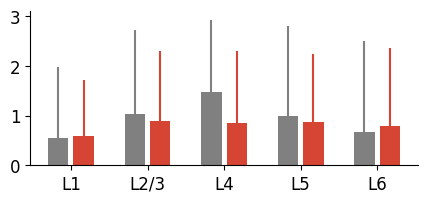

In [196]:
fig, ax = plt.subplots(1, 1, figsize=(5, 2))

# L1
ax.errorbar(
    x=0, y=np.exp(l1_out_vivo["mean"]), yerr=np.exp(l1_out_vivo["std"]), color=l1_color
)
ax.bar(x=0, height=np.exp(l1_out_vivo["mean"]), color=l1_color)
ax.errorbar(
    x=1,
    y=np.exp(l1_out_silico["mean"]),
    yerr=np.exp(l1_out_silico["std"]),
    color=silico_color,
)
ax.bar(x=1, height=np.exp(l1_out_silico["mean"]), color=silico_color)

# l2/3
ax.errorbar(
    x=3,
    y=np.exp(l2_3_out_vivo["mean"]),
    yerr=np.exp(l2_3_out_vivo["std"]),
    color=l2_3_color,
)
ax.bar(x=3, height=np.exp(l2_3_out_vivo["mean"]), color=l2_3_color)
ax.errorbar(
    x=4,
    y=np.exp(l2_3_out_silico["mean"]),
    yerr=np.exp(l2_3_out_silico["std"]),
    color=silico_color,
)
ax.bar(x=4, height=np.exp(l2_3_out_silico["mean"]), color=silico_color)

# l4
ax.errorbar(
    x=6, y=np.exp(l4_out_vivo["mean"]), yerr=np.exp(l4_out_vivo["std"]), color=l4_color
)
ax.bar(x=6, height=np.exp(l4_out_vivo["mean"]), color=l4_color)
ax.errorbar(
    x=7,
    y=np.exp(l4_out_silico["mean"]),
    yerr=np.exp(l4_out_silico["std"]),
    color=silico_color,
)
ax.bar(x=7, height=np.exp(l4_out_silico["mean"]), color=silico_color)

# l5
ax.errorbar(
    x=9, y=np.exp(l5_out_vivo["mean"]), yerr=np.exp(l5_out_vivo["std"]), color=l5_color
)
ax.bar(x=9, height=np.exp(l5_out_vivo["mean"]), color=l5_color)
ax.errorbar(
    x=10,
    y=np.exp(l5_out_silico["mean"]),
    yerr=np.exp(l5_out_silico["std"]),
    color=silico_color,
)
ax.bar(x=10, height=np.exp(l5_out_silico["mean"]), color=silico_color)

# l6
ax.errorbar(
    x=12, y=np.exp(l6_out_vivo["mean"]), yerr=np.exp(l6_out_vivo["std"]), color=l6_color
)
ax.bar(x=12, height=np.exp(l6_out_vivo["mean"]), color=l6_color)
ax.errorbar(
    x=13,
    y=np.exp(l6_out_silico["mean"]),
    yerr=np.exp(l6_out_silico["std"]),
    color=silico_color,
)
ax.bar(x=13, height=np.exp(l6_out_silico["mean"]), color=silico_color)

# set legend
ax.set_ylim([0, 3.1])
ax.spines[["top", "right"]].set_visible(False)
ax.set_xticks([0.5, 3.5, 6.5, 9.5, 12.5])
ax.set_xticklabels(["L1", "L2/3", "L4", "L5", "L6"], fontsize=12)
ax.tick_params(axis="y", labelsize=12)

# save figures
plt.savefig("figures/2_realism/6_firing_rate/pdf/layerwise_sorted_horvath_stats.pdf")
plt.savefig("figures/2_realism/6_firing_rate/svg/layerwise_sorted_horvath_stats.svg")

In [13]:
# total difference between mean firing rates
diff = (
    (np.exp(l1_out_vivo["mean"]) - np.exp(l1_out_silico["mean"]))
    + (np.exp(l2_3_out_vivo["mean"]) - np.exp(l2_3_out_silico["mean"]))
    + (np.exp(l4_out_vivo["mean"]) - np.exp(l4_out_silico["mean"]))
    + (np.exp(l5_out_vivo["mean"]) - np.exp(l5_out_silico["mean"]))
    + (np.exp(l6_out_vivo["mean"]) - np.exp(l6_out_silico["mean"]))
)

print(diff)
print(-(np.exp(l1_out_vivo["mean"]) - np.exp(l1_out_silico["mean"])))

0.86245243776674
0.03623795976655919


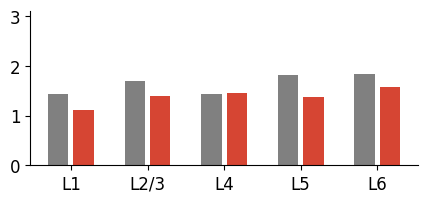

In [198]:
fig, ax = plt.subplots(1, 1, figsize=(5, 2))

# L1
ax.bar(x=0, height=np.exp(l1_out_vivo["std"]), color=l1_color)
ax.bar(x=1, height=np.exp(l1_out_silico["std"]), color=silico_color)

# l2/3
ax.bar(x=3, height=np.exp(l2_3_out_vivo["std"]), color=l2_3_color)
ax.bar(x=4, height=np.exp(l2_3_out_silico["std"]), color=silico_color)

# l4
ax.bar(x=6, height=np.exp(l4_out_vivo["std"]), color=l4_color)
ax.bar(x=7, height=np.exp(l4_out_silico["std"]), color=silico_color)

# l5
ax.bar(x=9, height=np.exp(l5_out_vivo["std"]), color=l5_color)
ax.bar(x=10, height=np.exp(l5_out_silico["std"]), color=silico_color)

# l6
ax.bar(x=12, height=np.exp(l6_out_vivo["std"]), color=l6_color)
ax.bar(x=13, height=np.exp(l6_out_silico["std"]), color=silico_color)

ax.set_ylim([0, 3.1])
ax.spines[["top", "right"]].set_visible(False)
ax.set_xticks([0.5, 3.5, 6.5, 9.5, 12.5])
ax.set_xticklabels(["L1", "L2/3", "L4", "L5", "L6"], fontsize=12)
ax.tick_params(axis="y", labelsize=12)

# save figures
plt.savefig("figures/2_realism/6_firing_rate/pdf/layerwise_sorted_horvath_std.pdf")
plt.savefig("figures/2_realism/6_firing_rate/svg/layerwise_sorted_horvath_std.svg")